# Imports

In [5]:
from fastai.vision.widgets import *
import fastbook
from fastbook import *

In [2]:
path=Path('chest_xray')

In [3]:
path.ls()

(#5) [Path('chest_xray/train'),Path('chest_xray/test'),Path('chest_xray/__MACOSX'),Path('chest_xray/.ipynb_checkpoints'),Path('chest_xray/val')]

##### There are one folder for the training set, one for the validation set and one for the test set.

In [4]:
#Let's have a look at the number of images for each folder.
(path/'val'/'PNEUMONIA').ls(),(path/'val'/'NORMAL').ls()

((#8) [Path('chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'),Path('chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'),Path('chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'),Path('chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'),Path('chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'),Path('chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg'),Path('chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'),Path('chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg')],
 (#8) [Path('chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'),Path('chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg')])

In [6]:
# The validation set contains only 16 images, it will not be enough in order to validate our model. 
#Let's have a look at the test set. May be we can merge test and val set to create a good validation set.
(path/'test'/'PNEUMONIA').ls(),(path/'test'/'NORMAL').ls()

((#390) [Path('chest_xray/test/PNEUMONIA/person99_bacteria_473.jpeg'),Path('chest_xray/test/PNEUMONIA/person1_virus_8.jpeg'),Path('chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg'),Path('chest_xray/test/PNEUMONIA/person150_bacteria_717.jpeg'),Path('chest_xray/test/PNEUMONIA/person1664_virus_2877.jpeg'),Path('chest_xray/test/PNEUMONIA/person171_bacteria_826.jpeg'),Path('chest_xray/test/PNEUMONIA/person139_bacteria_664.jpeg'),Path('chest_xray/test/PNEUMONIA/person86_bacteria_428.jpeg'),Path('chest_xray/test/PNEUMONIA/person85_bacteria_423.jpeg'),Path('chest_xray/test/PNEUMONIA/person94_bacteria_456.jpeg')...],
 (#234) [Path('chest_xray/test/NORMAL/IM-0061-0001.jpeg'),Path('chest_xray/test/NORMAL/NORMAL2-IM-0349-0001.jpeg'),Path('chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg'),Path('chest_xray/test/NORMAL/IM-0022-0001.jpeg'),Path('chest_xray/test/NORMAL/NORMAL2-IM-0079-0001.jpeg'),Path('chest_xray/test/NORMAL/NORMAL2-IM-0370-0001.jpeg'),Path('chest_xray/test/NORMAL/NORMAL2-IM-002

Our validation set will be composed of the testing set and the validation set. It will create a validation set of 642 images.

# Prepare the Data for an Exploratory Data Analysis

In [8]:
#Using the DataBlockAPI
pneumonia=DataBlock(
    #types for the independent (Image) and dependent variables (category Pneumonia or Normal).
    blocks=(ImageBlock, CategoryBlock),
    #returns a list of all the images in the path (it takes a path as argument).
    get_items=get_image_files,
    #split the data into validation and training set based on folder name.
    splitter=GrandparentSplitter(train_name='train', valid_name=('val','test')),
    #creates labels for the dependent variable.
    get_y=parent_label,
    #resizing the images to the same size. I also used a technique called Presizing.
    item_tfms=Resize(460),
    #apply transforms to the training set.
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [10]:
#A DataLoaders includes validation and training DataLoaders. 
#DataLoader is a class that provides batches of a few items at a time to the GPU (64 items).
dls = pneumonia.dataloaders(path, bs=64)

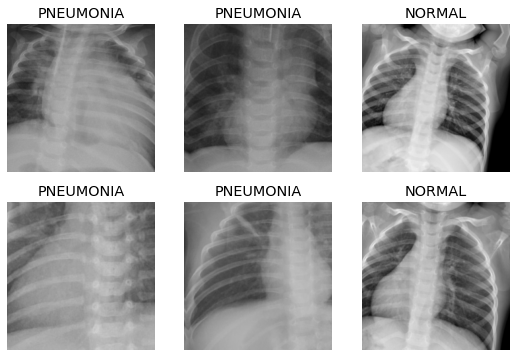

In [11]:
#Showing a few items of the training set.
dls.train.show_batch(max_n=6,nrows=2)

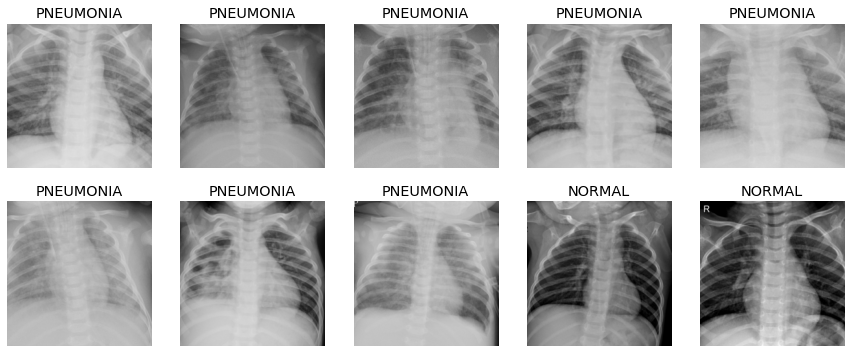

In [12]:
#Showing a few items of the validation set.
dls.valid.show_batch(max_n=10,nrows=2)

# Checking Data Augmentation

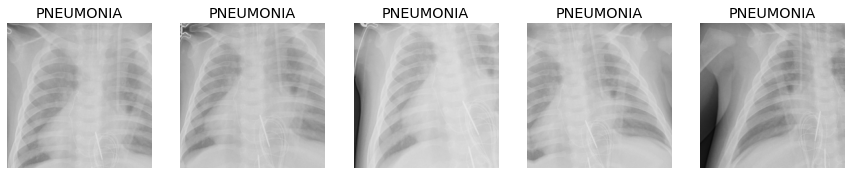

In [13]:
dls.train.show_batch(max_n=5,nrows=1,unique=True)

# Model Building

In [52]:
#Creating the model.
#I decided to use Resnet architecture. In particular I used Resnet34, it is just a restent with 34 layers. 
#I also used an ImageNet pretrained model.
learn=cnn_learner(dls,resnet34,pretrained=True,metrics=error_rate)

# Model Training

In order to find a good learning rate to train the last layers (the model is frozen), I will use the learning rate finder. We start with a small learning rate that we use for one mini-batch, track the loss then increase the learning rate (double it) for another mini-batch still tracking the loss. We do this until the loss starts getting worse.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.015848932787775993)

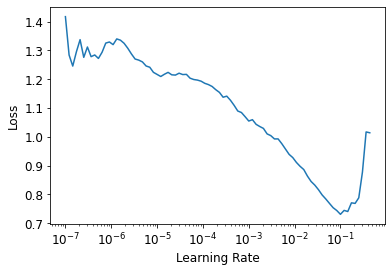

In [53]:
learn.lr_find()

In [54]:
lr=8e-3
learn.fit_one_cycle(4,max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.520006,0.447212,0.120312,00:38
1,0.280429,0.323228,0.092188,00:38
2,0.191083,0.331661,0.098438,00:37
3,0.167333,0.293000,0.079687,00:38


We updated the weights for the last layers but what about the earlier layers with the pretrained weights. What we can do is to unfreeze the model to tell gradient descent to updates all the weights of our neural net. After unfreezing we need to find out what is the best learning rate to train our model. The best way to do this is to use another time the learning rate finder.

In [55]:
learn.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.2908675418875646e-06)

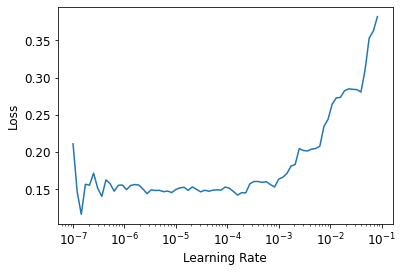

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.197899,4.045045,0.425000,00:49
1,0.164675,0.272710,0.110937,00:48
2,0.108544,0.259913,0.100000,00:48
3,0.077051,0.196381,0.073437,00:49


Now let us check the graph of the training and validation loss.

# Model Interpretation

Let's plot a confusion matrix in order to find out where our predictions failed.

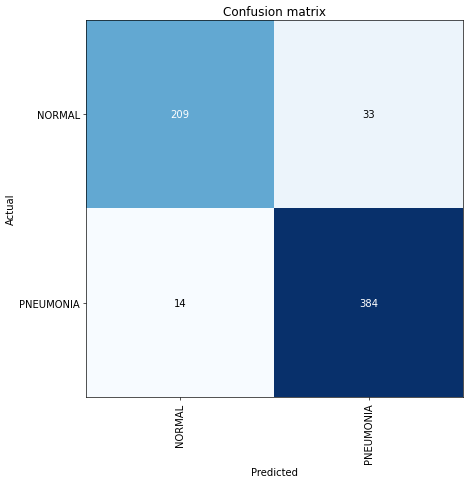

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

# Saving the model 

In [59]:
learn.export()

# Checking if the model has been saved correctly

In [68]:
#checking if the file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [69]:
#loading the model for inference
learn_inf = load_learner(path/'export.pkl')

In [70]:
#making one prediction
learn_inf.predict('chest_xray/test/PNEUMONIA/person1_virus_11.jpeg')

('PNEUMONIA', tensor(1), tensor([0.0017, 0.9983]))